In [1]:
import os
import json
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn.model_selection import learning_curve
from datetime import datetime
import plotly.express as px
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import joblib 
import json

In [2]:
os.chdir('..')

# Define Functions

In [3]:
def get_score(model, df):
    X_train, X_test, y_train, y_test = preparePredictiveData(df, date1)
    print("{}: {}".format(type(model).__name__, model.score(X_test, y_test)))
    
def get_score2(model, x, y):
    # Split dataset into train and validation subsets:
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    print("{}: {}".format(type(model).__name__, model.score(X_test, y_test)))

def get_cvs(model, x, y, cv): 
    scores = cross_val_score(model, x, y, scoring='r2', cv=cv)
    print("R2: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
    
def get_feature_importance(model, x_cols): 
    return pd.DataFrame(model.feature_importances_, index = x_cols, columns=['importance']).sort_values('importance',ascending=False)

def get_coef(model, x_cols): 
    return pd.DataFrame(model.coef_, index = x_cols, columns=['coef']).sort_values('coef',ascending=False)

In [4]:
def get_cv_predicted(model, X, y): 
    y_pred = []
    y_index = []
    y_ = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred.extend(model.predict(X_test))
        y_index.extend(test_index) 
        y_.extend(y_test)
    return pd.DataFrame({'pred': y_pred, 'y': y_}, index=y_index)

In [5]:
# Add functions to test
lr = LinearRegression(normalize=True, n_jobs=-1)
rf = RandomForestRegressor(n_estimators = 50, max_depth = 16, n_jobs = -1, random_state=0)
kf = KFold(n_splits=5, shuffle=True, random_state=None)
tscv = TimeSeriesSplit(n_splits = 5)

# Import Data

In [6]:
df_lr = pd.read_csv('ENG_DATA/SELECTED/05-14_lr_log.csv', index_col = [0])
df_rf = pd.read_csv('ENG_DATA/SELECTED/05-14_rfe_all.csv', index_col = [0])
df_rf = df_rf.select_dtypes(exclude = 'object')
dates_neighborhoods = pd.read_csv('ENG_DATA/SELECTED/05-13_sale_neighborhood_train.csv', index_col = [0], parse_dates = ["sale_date"])

In [7]:
date1 = date(2016, 12, 31)
df_lr = df_lr.merge(dates_neighborhoods, left_index = True, right_index = True).drop("neighborhood", axis=1)
df_rf = df_rf.merge(dates_neighborhoods, left_index = True, right_index = True).drop("neighborhood", axis=1)

In [8]:
lr_cols = df_lr.drop(["sale_price", "sale_date"], axis=1).columns
rf_cols = df_rf.drop(["sale_price", "sale_date"], axis=1).columns

In [9]:
df_lr.sort_values(by="sale_date", inplace=True)
df_rf.sort_values(by="sale_date", inplace=True)

In [10]:
scoring_params = ('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'explained_variance')

# Time-Series Data

In [119]:
lr_pred_scores = cross_validate(lr, df_lr.drop(["sale_price", "sale_date"], axis=1), df_lr.sale_price, scoring=scoring_params, cv=tscv, return_estimator=True)

In [118]:
rf_pred_scores = cross_validate(rf, df_rf.drop(["sale_price", "sale_date"], axis=1), df_rf.sale_price, scoring=scoring_params, cv=tscv, return_estimator=True)

In [14]:
predicted_ts_lr = get_cv_predicted(lr, df_lr.drop(["sale_price", "sale_date"], axis=1).values, df_lr.sale_price.values)
predicted_ts_rf = get_cv_predicted(rf, df_rf.drop(["sale_price", "sale_date"], axis=1).values, df_lr.sale_price.values)

In [15]:
predicted_ts = predicted_ts_lr.merge(predicted_ts_rf, left_index = True, right_index=True, suffixes=('_lr', '_rf'))

In [16]:
# predicted_ts = predicted_ts.merge(df_rf[["sale_date", "sale_price"]], left_index = True, right_index = True)

# Cross-Sectional Data

In [17]:
lr_cros_scores = cross_validate(lr, df_lr.drop(["sale_price", "sale_date"], axis=1), df_lr.sale_price, scoring=scoring_params, cv=kf, return_estimator=True, n_jobs=-1)
rf_cros_scores = cross_validate(rf, df_rf.drop(["sale_price", "sale_date"], axis=1), df_rf.sale_price, scoring=scoring_params, cv=kf, return_estimator=True, n_jobs=-1)

In [18]:
predicted_lr = cross_val_predict(lr, df_lr.drop(["sale_price", "sale_date"], axis=1), df_lr.sale_price, cv=kf)
predicted_rf = cross_val_predict(rf, df_rf.drop(["sale_price", "sale_date"], axis=1), df_rf.sale_price, cv=kf)

In [19]:
predicted_cs = df_lr[["sale_date", "sale_price"]].copy()

In [20]:
predicted_cs["pred_lr"] = predicted_lr
predicted_cs["pred_rf"] = predicted_rf

In [21]:
predicted_cs

,sale_date,sale_price,pred_lr,pred_rf
18534,2009-01-02,13.270783,13.163128,13.267727
19816,2009-01-05,13.353475,13.493256,13.318649
16521,2009-01-05,14.483340,14.473669,14.519008
20260,2009-01-05,13.610943,13.436363,13.563281
15269,2009-01-06,13.321214,13.076135,13.126962
...,...,...,...,...
18268,2018-12-31,14.648420,15.068610,14.790142
21267,2018-12-31,14.077875,14.611283,14.254783
4743,2018-12-31,14.308987,14.642765,14.352219
2624,2018-12-31,14.076335,14.082308,14.128012


# Table Results 

In [162]:
def parseResults(lr_, rf_): 
    lr__ = pd.DataFrame(lr_)
    rf__ = pd.DataFrame(rf_)
    lr__["model_name"] = "Linear Regression"
    rf__["model_name"] = "Random Forests"
    ret_ = pd.concat([lr__,rf__], axis=0, ignore_index=True)
    ret_["test_mean_error"] = ret_["test_r2"] - ret_["test_explained_variance"]
    ret_.drop(["fit_time", "score_time", "estimator", "test_explained_variance"], axis=1, inplace=True)
    return ret_

In [163]:
results_cs = parseResults(lr_cros_scores, rf_cros_scores)
results_cs["type"] = "Cross-Section"
results_ts = parseResults(lr_pred_scores, rf_pred_scores)
results_ts["type"] = "Time-Series"

In [175]:
ret2 = pd.concat([results_cs,results_ts], axis=0, ignore_index=True)

<Figure size 1080x504 with 0 Axes>

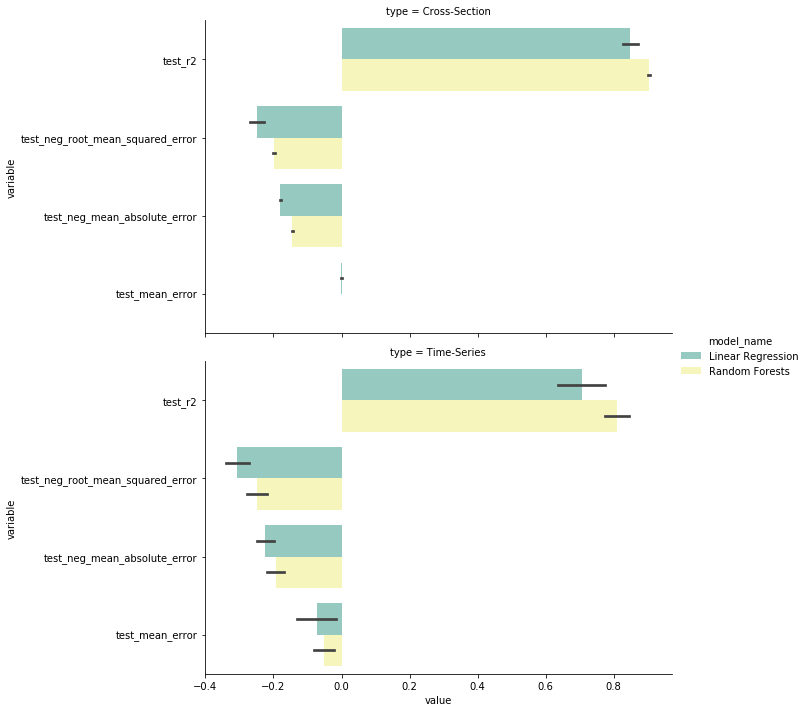

In [174]:
plt.figure(figsize=(15, 7))
g = sns.catplot(x = "value", y = "variable", row = "type", hue = "model_name", data=ret2.melt(id_vars = ["type", "model_name"]), orient="h", ci = "sd", height = 5, aspect = 2, palette="Set3",kind="bar")
g.savefig("RESULTS/results.png")

# Feature and Coefficient Frames

In [35]:
coefs = pd.DataFrame(
    [est.coef_ * df_lr.drop(["sale_price", "sale_date"], axis=1).std(axis=0)
     for est in lr_cros_scores['estimator']],
    columns=df_lr.drop(["sale_price", "sale_date"], axis=1).columns
)

In [45]:
coefs.where(np.abs(coefs) > 0.25).dropna(axis=1)

,longitude,latitude,elevation,on_market_year,elevation_2,on_market_year_2,longitude_2,burglary_2,assault_2,latitude_2
0,5105.017269,323.253724,0.374110,-39.591249,-0.436332,39.799411,-5105.055636,0.465791,-0.323777,-323.084148
1,5148.014730,312.865830,0.392207,-40.017259,-0.452303,40.226302,-5148.055651,0.460100,-0.309565,-312.697240
2,5195.556987,342.854897,0.398499,-43.762934,-0.459384,43.972644,-5195.594003,0.479094,-0.313807,-342.684051
3,5240.426495,344.178772,0.378044,-41.910559,-0.440937,42.119106,-5240.461751,0.417510,-0.295538,-344.006190
4,5148.954902,322.907907,0.364684,-42.122322,-0.424822,42.334660,-5148.992334,0.443616,-0.305144,-322.737957


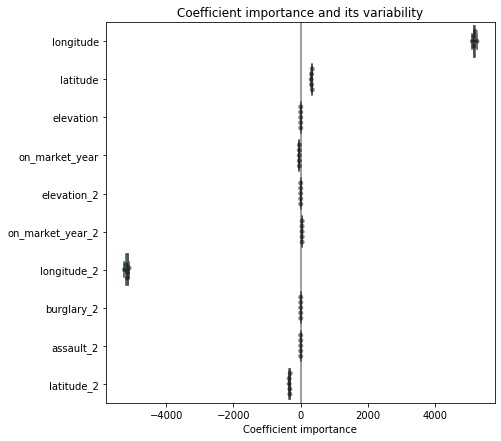

In [46]:
plt.figure(figsize=(9, 7))
sns.swarmplot(data=coefs.where(np.abs(coefs) > 0.25).dropna(axis=1), orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs.where(np.abs(coefs) > 0.25).dropna(axis=1), orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

In [50]:
fis = pd.DataFrame(
    [est.feature_importances_ 
     for est in rf_cros_scores['estimator']],
    columns=df_rf.drop(["sale_price", "sale_date"], axis=1).columns
)

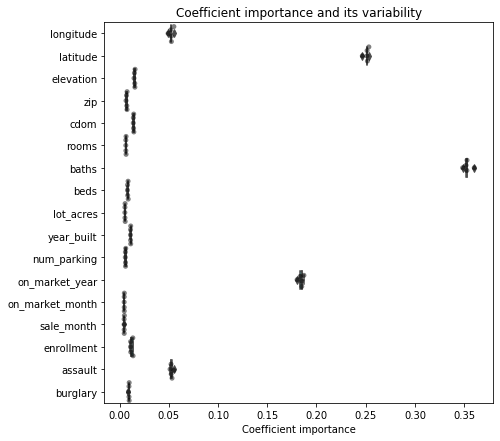

In [54]:
plt.figure(figsize=(9, 7))
sns.swarmplot(data=fis, orient='h', color='k', alpha=0.5)
sns.boxplot(data=fis, orient='h', color='cyan', saturation=0.5)
# plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

In [55]:
coefs

,longitude,latitude,elevation,zip,cdom,rooms,baths,beds,lot_acres,year_built,...,enrollment_2,longitude_2,burglary_2,assault_2,zip_2,latitude_2,rooms_2,on_market_month_2,year_built_2,sale_month_2
0,5105.017269,323.253724,0.374110,0.327352,-0.048476,-0.074613,-0.025532,0.115289,-0.097136,0.258135,...,0.132503,-5105.055636,0.465791,-0.323777,-0.328462,-323.084148,0.067002,-0.026802,-0.260654,-0.028955
1,5148.014730,312.865830,0.392207,-0.499071,-0.049477,-0.063976,-0.001820,0.058808,-0.068408,0.163931,...,0.143658,-5148.055651,0.460100,-0.309565,0.493940,-312.697240,0.054210,-0.014824,-0.168855,-0.034810
2,5195.556987,342.854897,0.398499,0.086516,-0.067246,-0.064118,-0.003935,0.059694,-0.058575,0.235249,...,0.095169,-5195.594003,0.479094,-0.313807,-0.085475,-342.684051,0.052287,-0.030446,-0.239588,-0.027318
3,5240.426495,344.178772,0.378044,0.146818,-0.046733,-0.070190,-0.006737,0.057266,-0.060827,0.225013,...,0.061308,-5240.461751,0.417510,-0.295538,-0.146221,-344.006190,0.060650,-0.022096,-0.229145,-0.037148
4,5148.954902,322.907907,0.364684,0.106447,-0.048034,-0.067657,-0.009012,0.055268,-0.056149,0.220146,...,0.134647,-5148.992334,0.443616,-0.305144,-0.105629,-322.737957,0.057289,-0.023510,-0.223276,-0.032249


Text(0.5, 1.0, 'Feature importance and its variability')

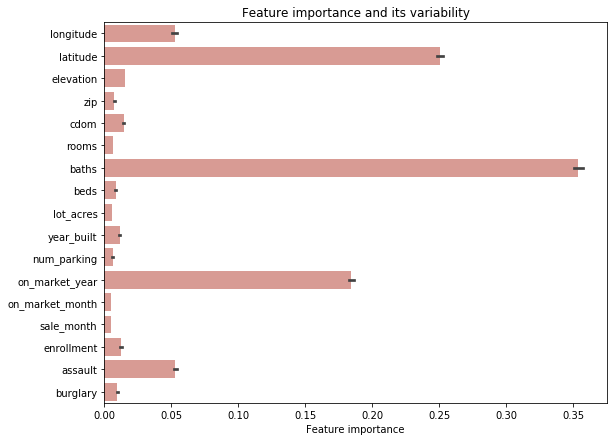

In [61]:
plt.figure(figsize=(9, 7))
sns.barplot(data=fis, color="salmon", saturation=.5, orient = "h")
plt.xlabel('Feature importance')
plt.title('Feature importance and its variability')

Text(0.5, 1.0, 'Coefficient importance and its variability')

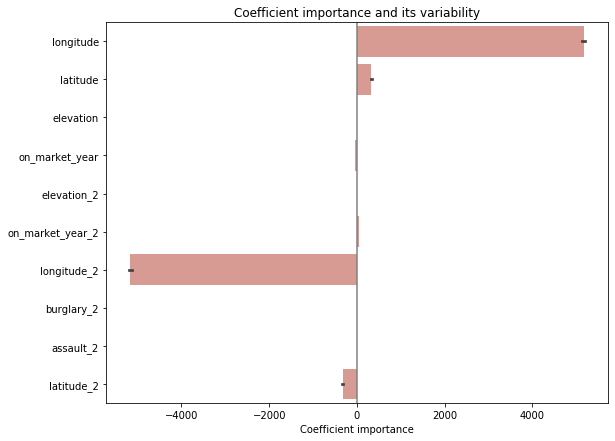

In [63]:
plt.figure(figsize=(9, 7))
sns.barplot(data=coefs.where(np.abs(coefs) > 0.25).dropna(axis=1), color="salmon", saturation=.5, orient = "h")
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')

# Learning Curves

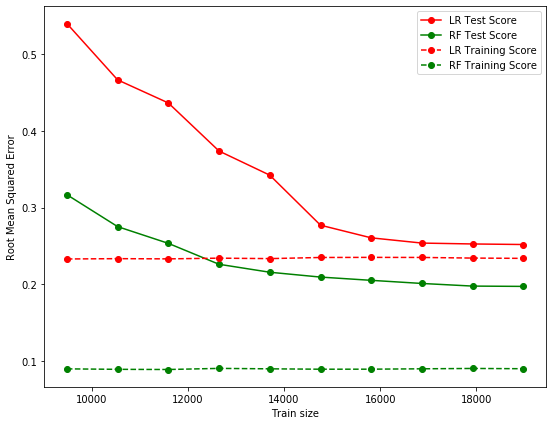

In [16]:
train_sizes, train_scores_lr, test_scores_lr = learning_curve(lr, df_lr.drop(["sale_price", "sale_date"], axis=1), df_lr.sale_price, scoring="neg_root_mean_squared_error", train_sizes=np.linspace(0.5, 1, 10), cv=kf)
train_sizes_abs, train_scores_rf, test_scores_rf = learning_curve(rf, df_rf.drop(["sale_price", "sale_date"], axis=1), df_rf.sale_price,scoring="neg_root_mean_squared_error", train_sizes=np.linspace(0.5, 1, 10), cv=kf)
plt.figure(figsize=(9, 7))
# fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plt.plot(train_sizes, -test_scores_lr.mean(1), 'o-', color="r",
         label="LR Test Score")
plt.plot(train_sizes, -test_scores_rf.mean(1), 'o-', color="g",
         label="RF Test Score")
plt.plot(train_sizes, -train_scores_lr.mean(1), 'o--', color="r",
         label="LR Training Score")
plt.plot(train_sizes, -train_scores_rf.mean(1), 'o--', color="g",
         label="RF Training Score")
plt.xlabel("Train size")
plt.ylabel("Root Mean Squared Error")
plt.legend(loc="best")
plt.show()

# Visualizations

In [ ]:
fig = px.scatter(df_output, x="sale_date", y="pred_diff", trendline = "ols", title= "Difference in Prediction Over 2-Year Test Data")
fig.show()

In [ ]:
df_melted = df_output[["sale_date", "sale_price", "predlr", "predrf"]].melt(id_vars = "sale_date")

In [ ]:
fig = px.scatter(df_melted, x="sale_date", y="value", color = "variable", title= "Predictions Over 2-Year Test Data")
fig.show()

In [ ]:
fig = px.scatter(df_melted.query("value < 15e6"), x="sale_date", y="value", color = "variable", title= "Predictions Over 2-Year Test Data")
fig.show()

In [ ]:
df_output['sale_price_bins'] = pd.qcut(df_output['sale_price'], 10, False)

In [ ]:
df_binned = df_output.groupby('sale_price_bins').mean()
df_binned.reset_index(inplace=True)
df_melted_bins = df_binned[["sale_price_bins", "sale_price", "predlr", "predrf"]].melt(id_vars = "sale_price_bins")

In [ ]:
fig = px.bar(df_melted_bins, x="sale_price_bins", y="value", color = "variable", barmode='group', title= "Sale-Price Quintile Binned Bar Chart of Prediction ")
fig.show()

In [ ]:
df_output['sale_date_bins'] = pd.qcut(df_output['sale_date'], 10, False)

In [ ]:
df_binned_2 = df_output.groupby('sale_date_bins').mean()
df_binned_2.reset_index(inplace=True)
df_melted_bins_2 = df_binned_2[["sale_date_bins", "sale_price", "predlr", "predrf"]].melt(id_vars = "sale_date_bins")

In [ ]:
fig = px.bar(df_melted_bins_2, x="sale_date_bins", y="value", color = "variable", barmode='group', title= "Time-Based Quintile Binned Bar Chart of Prediction ")
fig.show()

In [ ]:
def r_squared(data):
    d = {}
    d['r2-lr'] = r2_score(data['sale_price'], data['predlr'])
    d['r2-rf'] = r2_score(data['sale_price'], data['predrf'])
    return pd.Series(d)

In [ ]:
df_r2_binned = df_output.groupby('sale_date_bins').apply(r_squared)

In [ ]:
df_r2_binned.reset_index(inplace=True)

In [ ]:
fig = px.line(df_r2_binned.melt(id_vars = 'sale_date_bins'), x="sale_date_bins", y="value", color = "variable", title= "Time-Based Quintile Binned R-Squared Comparison")
fig.show()

# Log Transformation
## plot sale price before and after
heredoskadacitiy 

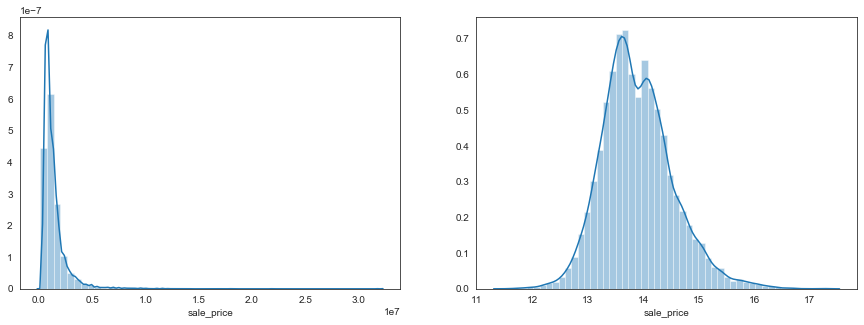

In [56]:
sns.set_style("white")
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(np.exp(df_lr['sale_price']), ax=ax[0])
sns.distplot(df_lr['sale_price'], ax=ax[1])
plt.show()

In [186]:
df_sales = df_lr[["sale_price", "sale_date"]].copy()

In [188]:
df_sales['date_ordinal'] = df_sales['sale_date'].apply(lambda x: x.toordinal())

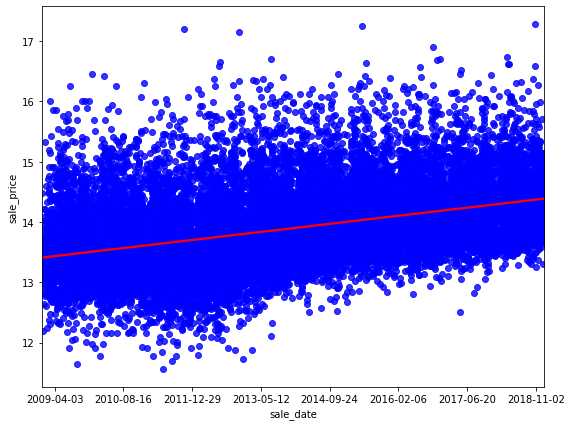

In [200]:
plt.figure(figsize=(9, 7))
s = sns.regplot(
    data=df_sales,
    x='date_ordinal',
    y='sale_price', scatter_kws={"color": "blue"}, line_kws={"color": "red"}
)
# Tighten up the axes for prettiness
s.set_xlim(df_sales['date_ordinal'].min() - 1, df_sales['date_ordinal'].max() + 1)
s.set_xlabel('sale_date')
new_labels = [date.fromordinal(int(item)) for item in s.get_xticks()]
s.set_xticklabels(new_labels)
s.figure.savefig("RESULTS/feature_visualization/results.png")

# Export

In [205]:
def export_df(df_, name_):
    month_day = datetime.now().strftime('%m-%d')
    df_.to_csv('ENG_DATA/RESULTS/{}_{}.csv'.format(month_day, name_))

In [206]:
export_df(ret2, "results")

In [208]:
export_df(coefs, "lr_coef")
export_df(fis, "rf_fi")

In [ ]:
export_df()